# 分类（mnist） 

## 数据集探索

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

d:\anaconda\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

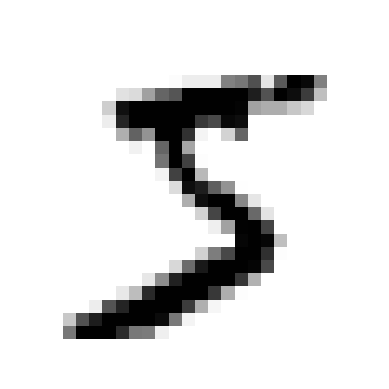

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy()  # 如果 X 是 DataFrame，先转换为 NumPy 数组
some_digit_image = some_digit.reshape(28, 28)   # 把一维数组转换为二维数组

plt.imshow(some_digit_image, cmap="binary") # 使用 Matplotlib 的 imshow 函数
plt.axis("off") # 不显示坐标轴

plt.show() # 展示图像


In [26]:
y[0]

import numpy as np  

y = y.astype(np.uint8)  # 将字符串转换为整数

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]    # 前 60000 个样本为训练集，后 10000 个样本为测试集

y_train_5 = y_train_5.astype(int)  # y_test_5 表示测试集中数字是否为 5

## SGD随机梯度下降

In [24]:
from  sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train.to_numpy() , y_train_5)

sgd_clf.predict([some_digit])

array([1])

#### 性能测量

In [27]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train.to_numpy(), y_train_5, cv=3, scoring="accuracy") # 交叉验证


array([0.95035, 0.96035, 0.9604 ])

In [29]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train.to_numpy(), y_train_5, cv=3, scoring="accuracy")  # 交叉验证

array([0.91125, 0.90855, 0.90915])

把每张图都认定为非5的准确率都有90%

### 混淆矩阵

In [31]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train.to_numpy(), y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)  # 混淆矩阵

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [33]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # 精度

print(recall_score(y_train_5, y_train_pred))  # 召回率

from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred))  # F1 值


0.8370879772350012
0.6511713705958311
0.7325171197343846


In [34]:
y_scores = sgd_clf.decision_function([some_digit])   # decision_function() 方法返回每个样本的分数值
y_scores

array([2164.22030239])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) # 根据阈值判断是否为 5
y_some_digit_pred

array([ True])

In [37]:
threshold = 8000    # 提高阈值
y_some_digit_pred = (y_scores > threshold) # 根据阈值判断是否为 5
y_some_digit_pred

array([False])

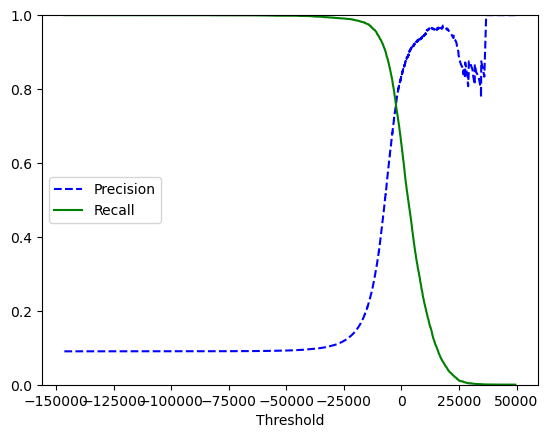

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train.to_numpy(), y_train_5, cv=3, method="decision_function")  # 返回每个样本的分数值

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)  # 计算不同阈值下的精度和召回率

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):  # 绘制精度和召回率随阈值变化的曲线
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")   # 精度
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")   # 召回率
    plt.xlabel("Threshold")  # x 轴为阈值  
    plt.legend(loc="center left")  # 图例
    plt.ylim([0, 1])        # y 轴范围

plot_precision_recall_vs_threshold(precisions, recalls, thresholds) # 绘制精度和召回率随阈值变化的曲线
plt.show()

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # 精度达到 90% 的最小阈值
threshold_90_precision

3370.0194991439594

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)  #以该阈值进行预测
print(precision_score(y_train_5, y_train_pred_90))  # 精度

0.9000345901072293


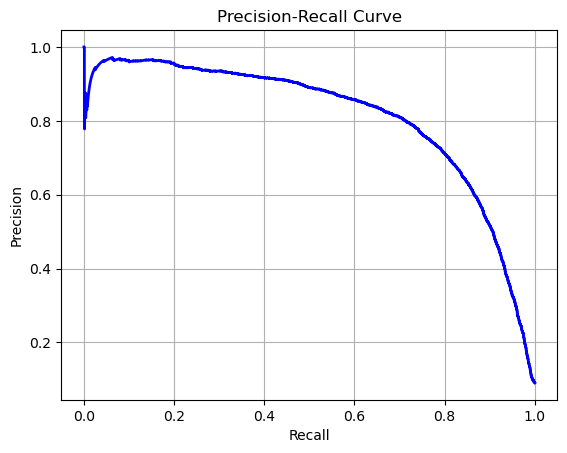

In [42]:
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

### ROC 曲线

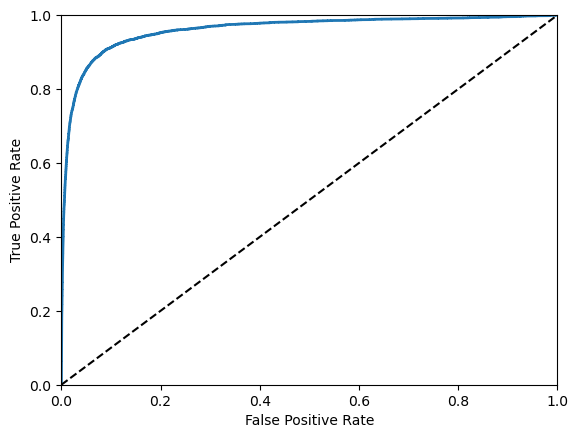

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)  # 计算不同阈值下的 FPR 和 TPR

def plot_roc_curve(fpr, tpr, label=None):  # 绘制 ROC 曲线
    plt.plot(fpr, tpr, linewidth=2, label=label)  # FPR 为 x 轴，TPR 为 y 轴
    plt.plot([0, 1], [0, 1], 'k--')  # 对角虚线
    plt.axis([0, 1, 0, 1])  # x、y 轴范围
    plt.xlabel('False Positive Rate')  # FPR
    plt.ylabel('True Positive Rate')   # TPR

plot_roc_curve(fpr, tpr)  # 绘制 ROC 曲线

In [46]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)  # 计算 ROC 曲线下的面积

0.9604938554008616

In [48]:
forest_clf.fit(X_train, y_train_5)
forest_clf.predict(X_test)

array([0, 0, 0, ..., 0, 1, 0])

In [49]:
cross_val_score(forest_clf, X_train.to_numpy(), y_train_5, cv=3, scoring="accuracy") # 交叉验证

array([0.98885, 0.9863 , 0.98635])

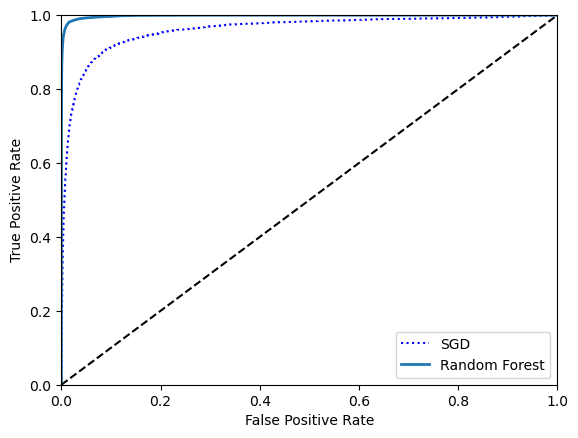

In [47]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train.to_numpy(), y_train_5, cv=3, method="predict_proba")  # 返回每个样本的分数值

y_scores_forest = y_probas_forest[:, 1]  # 正类的概率

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)  # 计算不同阈值下的 FPR 和 TPR

plt.plot(fpr, tpr, "b:", label="SGD")  # SGD 的 ROC 曲线

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")  # 随机森林的 ROC 曲线
plt.legend(loc="lower right")  # 图例
plt.show()


In [50]:
# 计算 ROC 曲线下的面积
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [55]:
# SVM分类
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train.to_numpy(),y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit]) # decision_function() 方法返回每个样本的分数值
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [58]:
print(np.argmax(some_digit_scores))  # 最高分数的索引
svm_clf.classes_  # 类别

5


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
## 使用OvR sklearn
from sklearn.multiclass import OneVsRestClassifier # 多类别分类

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train.to_numpy(), y_train)
ovr_clf.predict([some_digit])

len(ovr_clf.estimators_)  # 估计器数量

10

In [60]:
sgd_clf.fit(X_train.to_numpy(), y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [61]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [62]:
cross_val_score(sgd_clf, X_train.to_numpy(), y_train, cv=3, scoring="accuracy")  # 交叉验证

array([0.87365, 0.85835, 0.8689 ])

In [63]:
## 对输入进行缩放后使用sgd进行预测

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")  # 交叉验证


array([0.8983, 0.891 , 0.9018])

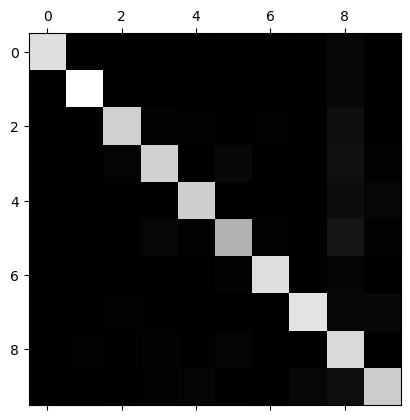

In [64]:
##绘制多分类混淆矩阵（sgd模型）

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)    # 用sgd_clf进行预测
conf_mx = confusion_matrix(y_train, y_train_pred)  # 混淆矩阵

plt.matshow(conf_mx, cmap=plt.cm.gray)  # 绘制混淆矩阵
plt.show()

## 多标签分类

In [66]:
#使用knn进行多分类
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)  # 大于等于 7
y_train_odd = (y_train % 2 == 1)  # 奇数
y_multilabel = np.c_[y_train_large, y_train_odd]  # 多标签

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)


KNeighborsClassifier()

In [67]:
knn_clf.predict([some_digit])

d:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [69]:
# 使用F1值进行多标签分类评估
y_train_knn_pred = cross_val_predict(knn_clf, X_train_scaled, y_multilabel, cv=3) # 交叉验证
f1_score(y_multilabel, y_train_knn_pred, average="macro")  # F1 值


0.9613989329409902

d:\anaconda\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


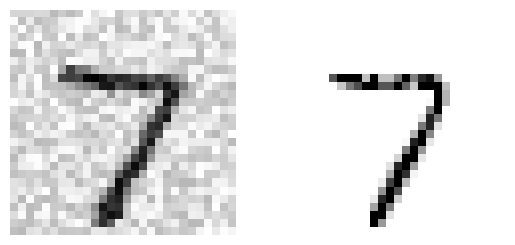

In [70]:
# 多输出分类
noise = np.random.randint(0, 100, (len(X_train), 784))  # 添加噪声
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))  # 添加噪声
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

some_index = 0

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])  # 清理图像
clean_digit = clean_digit[0]

some_digit = X_test_mod.iloc[some_index].to_numpy()  # 如果 X 是 DataFrame，先转换为 NumPy 数组
some_digit_image = some_digit.reshape(28, 28)   # 把一维数组转换为二维数组

clean_digit = clean_digit.reshape(28, 28)   # 把一维数组转换为二维数组

plt.subplot(121)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.imshow(clean_digit, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
